# ML flow:

## Setting up

In [1]:
# run script that installs missing libraries
! chmod 755 ../../scripts.sh
! ../../scripts.sh

# run script that installs missing libraries
! chmod 755 ../../ML_scripts.sh
! ../../ML_scripts.sh

  Using cached cf_units-3.0.1.post0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
  Using cached antlr4_python3_runtime-4.7.2-py3-none-any.whl
  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.7.5
    Uninstalling python-dateutil-2.7.5:
      Successfully uninstalled python-dateutil-2.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sat-stac 0.4.1 requires python-dateutil~=2.7.5, but you have python-dateutil 2.8.2 which is incompatible.
intake-esm 2021.8.17 requires h5netcdf>=0.8.1, but you have h5netcdf 0.0.0 which is incompatible.
earthdata 0.2.2 requires python-benedict<0.26,>=0.25, but you have python-benedict 0.24.3

### Imports:

In [37]:
import os
import sys
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from math import cos,sin,pi

sys.path.append('../')
from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *
#from MakeInputFunctions import *
from model import *


import torch
import keras
import tensorflow as tf 
from keras import backend as K
from tensorflow.python.keras.backend import set_session

from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose, Reshape, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from netCDF4 import Dataset
import random as rn
from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions:

In [38]:
def plotAllVar(GCM_xy, m=3, n=3, name="GCM", time=0):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=time).plot(
            ax=ax, x="x", y="y", transform=ccrs.SouthPolarStereo(), add_colorbar=True
        )
        ax.coastlines("10m", color="black")
        ax.gridlines()
        ax.set_title(f"{GCM_xy[var].long_name} ({var})")
    plt.suptitle(f"First time step {GCM_xy.time[0].values} of {name}")

In [39]:
def resize(df, sizex, sizey, print_=True):
    # resize to input domain size:
    if print_:
        print("Shape before resizing:", df.shape)
    image = tf.constant(df)
    image_resized = tf.image.resize(image, (sizex, sizey))
    df_resized = image_resized.numpy()
    if print_:
        print("Shape after resizing:", df_resized.shape)

    return df_resized

In [40]:
def cutBoundaries(df, max_x, max_y, lowerHalf = False):
    df = df.where(df.x < max_x, drop=True)
    df = df.where(-max_x <= df.x, drop=True)
    if lowerHalf:
        df = df.where(df.y < 0, drop=True)
    else:
        df = df.where(df.y < max_y, drop=True)
    df = df.where(-max_y <= df.y, drop=True)
    return df

In [41]:
def takeRandomSamples(full_input, full_target, pred=False, full_prediction=None):
    randTime = rn.randint(1, len(full_input[0]))
    sample2dtrain = full_input[0][randTime]
    sample1dtrain = full_input[1][randTime]

    sampletarget = full_target[randTime]

    if pred:
        samplepred = full_prediction[randTime]

        return sample2dtrain, sample1dtrain, sampletarget, samplepred, randTime
    else:
        return sample2dtrain, sample1dtrain, sampletarget, randTime


def plotTrain(GCMLike, sample2dtrain, numVar, ax, time, list_var, region="whole antarctica"):
    if region == "lower peninsula":
        ds = createLowerInput(GCMLike, Nx=48, Ny=25, print_=False)

    elif region == "whole antarctica":
        ds = GCMLike

    VAR = list_var[numVar]
    coords = {"y": ds.coords["y"], "x": ds.coords["x"]}
    dftrain = xr.Dataset(coords=coords, attrs=ds.attrs)
    dftrain[VAR] = xr.Variable(
        dims=("y", "x"), data=sample2dtrain[:, :, numVar], attrs=ds[VAR].attrs
    )
    dftrain[VAR].plot(
        ax=ax, x="x", transform=ccrs.SouthPolarStereo(), add_colorbar=True
    )

    ax.coastlines("10m", color="black")
    ax.gridlines()

    ax.set_title(f"{time} Input: {VAR}")


def plotTarget(target_dataset, sampletarget, ax, region="whole antarctica"):
    if region == "lower peninsula":
        ds = createLowerTarget(target_dataset, Nx=64, Ny = 64, print_=False)

    elif region == "whole antarctica":
        ds = target_dataset

    coords = {"y": ds.coords["y"], "x": ds.coords["x"]}
    dftrain = xr.Dataset(coords=coords, attrs=ds.attrs)
    dftrain["SMB"] = xr.Variable(
        dims=("y", "x"), data=sampletarget[:, :, 0], attrs=ds["SMB"].attrs
    )
    dftrain.SMB.plot(ax=ax, x="x", transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines("10m", color="black")
    ax.gridlines()
    ax.set_title(f"Target: SMB")


def plotPred(target_dataset, samplepred, ax, region="whole antarctica"):
    if region == "lower peninsula":
        ds = createLowerTarget(target_dataset, Nx=64, Ny = 64, print_=False)

    elif region == "whole antarctica":
        ds = target_dataset
    coords = {"y": ds.coords["y"], "x": ds.coords["x"]}
    dftrain = xr.Dataset(coords=coords, attrs=ds.attrs)
    dftrain["SMB"] = xr.Variable(
        dims=("y", "x"), data=samplepred[:, :, 0], attrs=ds["SMB"].attrs
    )
    dftrain.SMB.plot(ax=ax, x="x", transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines("10m", color="black")
    ax.gridlines()
    ax.set_title(f"Prediction: SMB")

## Load data:

In [42]:
# Path on GC with data:
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'

### Input: GCM-like RCM
I.e., to create X, Z

In [43]:
fileGCMLike = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'
downloadFileFromGC(pathGC, '', fileGCMLike)
GCMLike = xr.open_dataset(fileGCMLike)
os.remove(fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen({'x': 90, 'y': 25, 'time': 1452})


<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

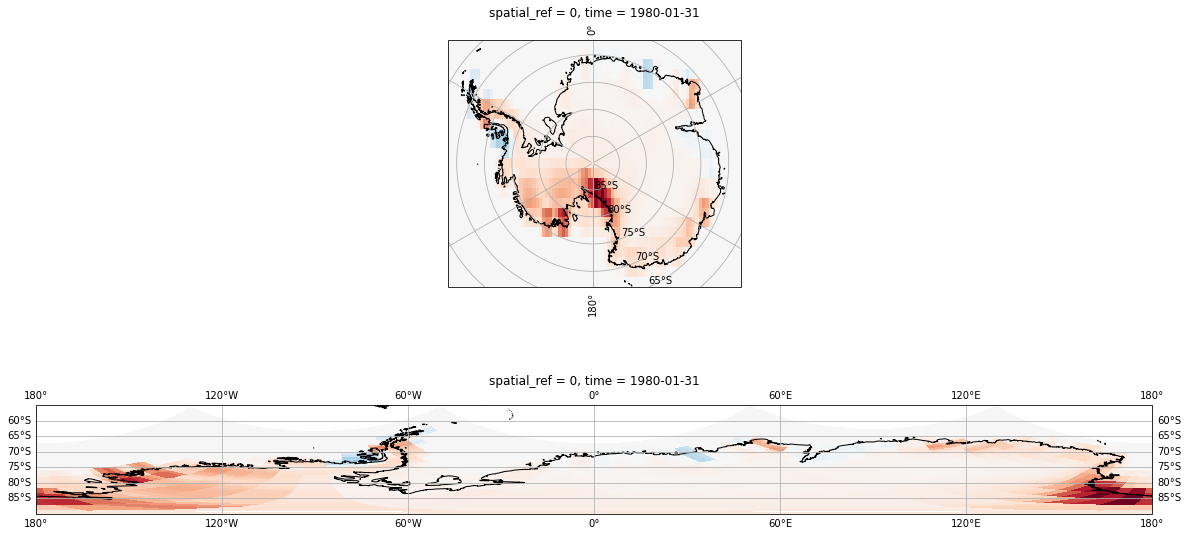

In [44]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)

ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)


ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)


ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### Target: RCM

In [45]:
# Open target file
fileTarget = 'MAR(ACCESS1-3)_monthly.nc'
downloadFileFromGC(pathGC, '', fileTarget)
target_dataset = xr.open_dataset(fileTarget)
os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7})
New target dimensions: Frozen({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7})


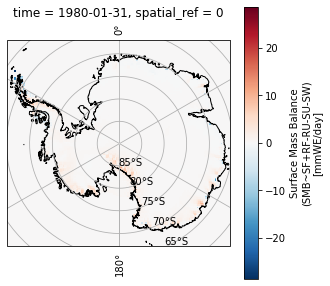

In [46]:
# plot
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
target_dataset.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=True
)

ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

## Cut to specific region:

### Target:
Cut to lower peninsula to get a 64x64 grid like in the paper.

In [47]:
def createLowerTarget(target_dataset, Nx=64, Ny = 64, print_=True):
    max_x = (Nx / 2) * 35 * 1000
    max_y = Ny * 35 * 1000

    lowerTarget = cutBoundaries(target_dataset, max_x, max_y, lowerHalf=True)

    if print_:
        print("New target dimensions:", lowerTarget.dims)

    return lowerTarget

New target dimensions: Frozen({'time': 1452, 'y': 64, 'x': 64, 'PLEV': 7})


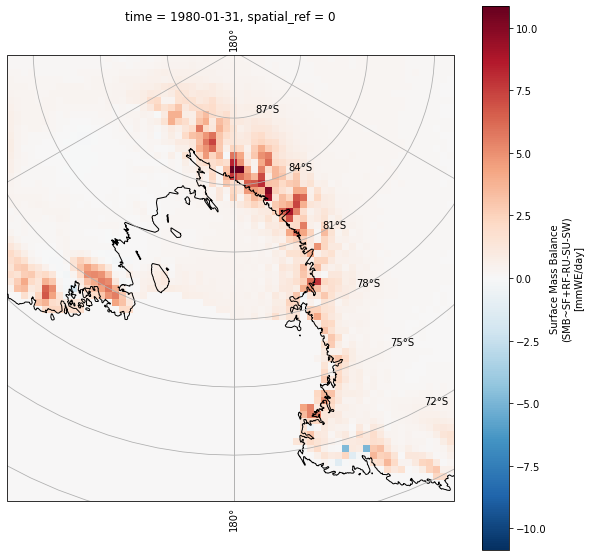

In [48]:
lowerTarget = createLowerTarget(target_dataset, Nx=64, Ny =64)

# plot
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
lowerTarget.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=True
)

ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### Input:
Cut to grid around target domain defined above, grid of 25x48, will resize later to 32x32 or 16x16

In [49]:
def createLowerInput(GCMLike, Nx=48, Ny=25, print_=True):
    max_x = (Nx / 2) * 68 * 1000
    max_y = (Ny / 2) * 206 * 1000

    lowerInput = cutBoundaries(GCMLike, max_x, max_y)
    if print_:
        print("New dimensions:", lowerInput.dims)

    return lowerInput

New dimensions: Frozen({'time': 1452, 'y': 25, 'x': 48})


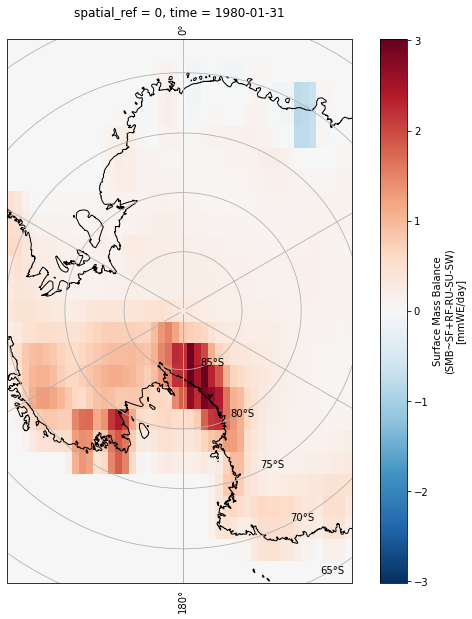

In [50]:
lowerInput = createLowerInput(GCMLike, Nx=48, Ny=25)

# plot
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
lowerInput.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=True
)

ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

## Create input:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

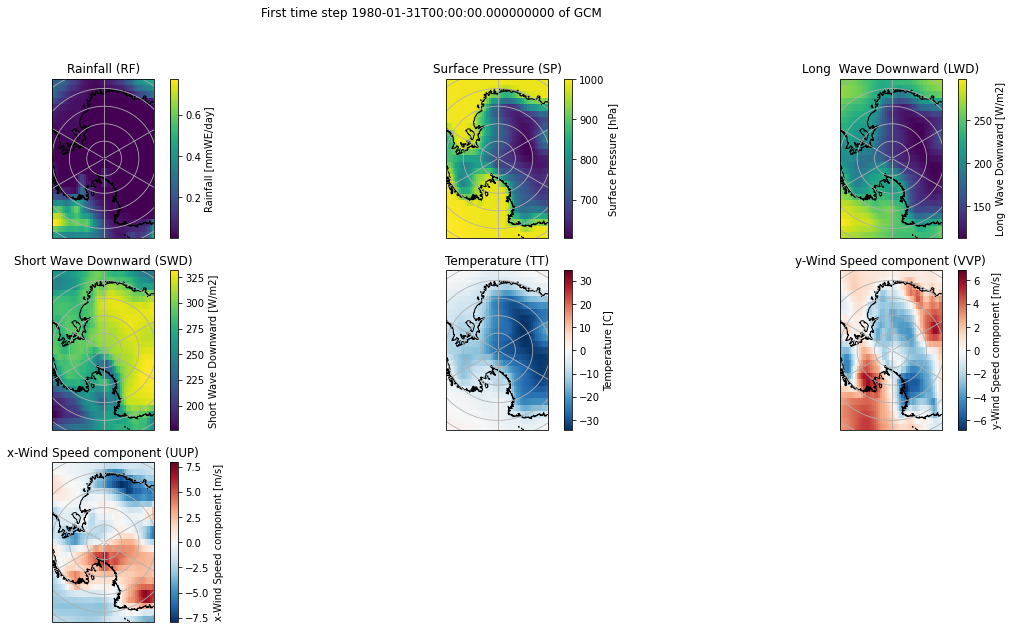

In [51]:
# Download GMC like RCM input data:
fileGCMLike = "MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc"
downloadFileFromGC(pathGC, "", fileGCMLike)
GCMLike = xr.open_dataset(fileGCMLike)
os.remove(fileGCMLike)

region = 'lower peninsula'
size_input_domain = 32
DATASET = GCMLike.drop(["SMB"])

DATASET = createLowerInput(DATASET, Nx=48, Ny=25, print_=False)
plotAllVar(DATASET)

In [52]:
def input_maker(
    GCMLike,
    size_input_domain=16,  # size of domain, format: 8,16,32, must be defined in advance
    stand=True,  # standardization
    seas=True,  # put a cos, sin vector to control the season, format : bool
    means=True,  # add the mean of the variables raw or stdz, format : bool
    stds=True,  # add the std of the variables raw or stdz, format : bool
    resize_input=True,  # resize input to size_input_domain
    region="lower peninsula",  # region of interest
    print_=True
):

    if region == "lower peninsula":
        DATASET = createLowerInput(GCMLike, Nx=48, Ny=25, print_=False)

    elif region == "whole antarctica":
        DATASET = GCMLike
    """
    MAKE THE 2D INPUT ARRAY
    SHAPE [nbmonths, x, y, nb_vars]
    """

    # Remove target variable from DATASET:
    DATASET = DATASET.drop(["SMB"])

    nbmonths = DATASET.dims["time"]
    x = DATASET.dims["x"]
    y = DATASET.dims["y"]
    nb_vars = len(list(DATASET.data_vars))
    VAR_LIST = list(DATASET.data_vars)

    INPUT_2D_bf = np.transpose(
        np.asarray([DATASET[i].values for i in VAR_LIST]), [1, 2, 3, 0]
    )

    # if no size is given, take smallest power of 2
    if size_input_domain == None:
        size_input_domain = np.max(
            [
                highestPowerof2(INPUT_2D_bf.shape[1]),
                highestPowerof2(INPUT_2D_bf.shape[2]),
            ]
        )

    if resize_input:
        # resize to size_input_domain
        INPUT_2D = resize(INPUT_2D_bf, size_input_domain, size_input_domain, print_)
    else:
        INPUT_2D = INPUT_2D_bf

    if stand:
        # Standardize:
        INPUT_2D_SDTZ = standardize(INPUT_2D)
        # in their code with aerosols extra stuff but ignore
        INPUT_2D_ARRAY = INPUT_2D_SDTZ
    else:
        INPUT_2D_ARRAY = INPUT_2D

    if print_:
        print("Parameters:\n -------------------")
        print("Size of input domain:", size_input_domain)
        print("Region:", region)
        print("\nCreating 2D input X:\n -------------------")
        print(f"Number of variables: {nb_vars}")
        print(f"Variables: {VAR_LIST}")
        print(f"INPUT_2D shape: {INPUT_2D_ARRAY.shape}")
        print("\nCreating 1D input Z:\n -------------------")
        
    """
    MAKE THE 1D INPUT ARRAY
    CONTAINS MEANS, STD SEASON IF ASKED
    """
    
    INPUT_1D = []
    if means and stds:
        vect_std = INPUT_2D.std(axis=(1, 2))
        vect_means = INPUT_2D.mean(axis=(1, 2))
        SpatialMean = vect_means.reshape(INPUT_2D.shape[0], 1, 1, INPUT_2D.shape[3])
        SpatialSTD = vect_std.reshape(INPUT_2D.shape[0], 1, 1, INPUT_2D.shape[3])

        INPUT_1D.append(SpatialMean)
        INPUT_1D.append(SpatialSTD)
        if print_:
            print(f"SpatialMean/std shape: {SpatialMean.shape}")

    if seas:
        months = 12
        cosvect = np.tile(
            [cos(2 * i * pi / months) for i in range(months)],
            int(INPUT_2D.shape[0] / months),
        )
        sinvect = np.tile(
            [sin(2 * i * pi / months) for i in range(months)],
            int(INPUT_2D.shape[0] / months),
        )
        cosvect = cosvect.reshape(INPUT_2D.shape[0], 1, 1, 1)
        sinvect = sinvect.reshape(INPUT_2D.shape[0], 1, 1, 1)

        INPUT_1D.append(cosvect)
        INPUT_1D.append(sinvect)
        if print_:
            print(f"Cos/sin encoding shape: {cosvect.shape}")

    INPUT_1D_ARRAY = np.concatenate(INPUT_1D, axis=3)
    if print_:
        print(f"INPUT_1D shape: {INPUT_1D_ARRAY.shape}")
        
    DATASET.close()
    return INPUT_2D_ARRAY, INPUT_1D_ARRAY, VAR_LIST

In [53]:
# Download GMC like RCM input data:
fileGCMLike = "MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc"
downloadFileFromGC(pathGC, "", fileGCMLike)
GCMLike = xr.open_dataset(fileGCMLike)
os.remove(fileGCMLike)

region = "lower peninsula"
size_input_domain = 32

# Make input
i2D, i1D, VAR_LIST = input_maker(
    GCMLike,
    size_input_domain,
    stand=True,  # standardization
    seas=True,  # put a cos,sin vector to control the season, format : bool
    means=True,  # add the mean of the variables raw or stdz, format : r,s,n
    stds=True,
    resize_input=True,
    region=region,
)

inputs_2D = []
inputs_1D = []
inputs_1D.append(i1D)
inputs_2D.append(i2D)

# Make a non standardised version for plots:
i2D_ns, i1D_ns, var_list = input_maker(
    GCMLike,
    size_input_domain,
    stand=False,  # standardization
    seas=True,  # put a cos,sin vector to control the season, format : bool
    means=True,  # add the mean of the variables raw or stdz, format : r,s,n
    stds=True,
    resize_input=False,
    region=region,
    print_=False,
)

inputs_2D_ns = []
inputs_1D_ns = []
inputs_1D_ns.append(i1D_ns)
inputs_2D_ns.append(i2D_ns)

Shape before resizing: (1452, 25, 48, 7)
Shape after resizing: (1452, 32, 32, 7)
Parameters:
 -------------------
Size of input domain: 32
Region: lower peninsula

Creating 2D input X:
 -------------------
Number of variables: 7
Variables: ['RF', 'SP', 'LWD', 'SWD', 'TT', 'VVP', 'UUP']
INPUT_2D shape: (1452, 32, 32, 7)

Creating 1D input Z:
 -------------------
SpatialMean/std shape: (1452, 1, 1, 7)
Cos/sin encoding shape: (1452, 1, 1, 1)
INPUT_1D shape: (1452, 1, 1, 16)


## Create target:

In [54]:
def target_maker(
    target_dataset, 
    region="whole antarctica", # region of interest
    resize=True, # resize to target_size
    target_size=None # if none provided and resize true, set to min highest power of 2
):
    target_times = []
    targets = []

    if region == "lower peninsula":
        lowerTarget = createLowerTarget(target_dataset, Nx=64, Ny=64, print_=False)
        targetArray = lowerTarget.SMB.values

    elif region == "whole antarctica":
        targetArray = target_dataset.SMB.values

    targetArray = targetArray.reshape(
        targetArray.shape[0], targetArray.shape[1], targetArray.shape[2], 1
    )

    if target_size == None:
        # resize to highest power of 2:
        target_size = np.min(
            [
                highestPowerof2(targetArray.shape[1]),
                highestPowerof2(targetArray.shape[2]),
            ]
        )

    if resize:
        target_SMB = resize(targetArray, target_size, target_size)
    else:
        target_SMB = targetArray

    targets.append(target_SMB)
    target_times.append(target_dataset.time.values)

    full_target = np.concatenate(targets, axis=0)

    return full_target, target_times

In [55]:
full_target, target_times = target_maker(
    target_dataset, region="lower peninsula", resize=False
)
# Full target to model
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

## U-Net:

In [56]:
SCENARIO=['HIST' , 'RCP85']
var_list = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'VVP', 'UUP']
var_pred = ['SMB']

In [57]:
# Full input to model
full_input=[np.concatenate(inputs_2D,axis=0),np.concatenate(inputs_1D,axis=0)]
full_input_ns=[np.concatenate(inputs_2D_ns,axis=0),np.concatenate(inputs_1D_ns,axis=0)]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 7)
Input 1D: (1452, 1, 1, 16)


Text(0.5, 1.0, 'Unstandardised')

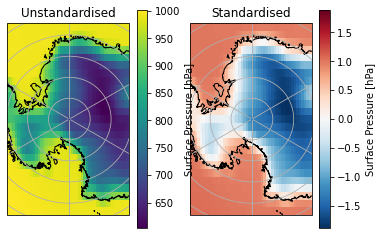

In [58]:
randTime = 0
dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
time = str(dt.date[0])

sample = full_input[0][randTime, :, :, :]
sample = resize(sample, 25, 48, print_=False)
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

plotTrain(GCMLike, sample, 1, ax, time, VAR_LIST, region)
ax.set_title("Standardised")
sample = full_input_ns[0][randTime, :, :, :]
sample = resize(sample, 25, 48, print_=False)
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
plotTrain(GCMLike, sample, 1, ax, time, VAR_LIST, region)
ax.set_title("Unstandardised")

### Build U-Net:

In [59]:
## In Doury et al (2022) we chose to mask the over seas values as we are not interested in them, we did so by setting them always to 0.
# Ignore for now....
path_model = 'Results/'

#conv = 32
filter_size = 64
# set seed
seed = 123
rn.seed(seed)

# We use here the unet_maker function defined in make_unet
unet=unet_maker(nb_inputs=len(full_input),
                size_target_domain=full_target.shape[1],
                shape_inputs=[A.shape[1:] for A in full_input],
                filters = filter_size, seed = seed)

LR = 0.005
unet.compile(optimizer=Adam(learning_rate=LR), loss="mse", metrics=[rmse_k])

Arguments to U-Net:
------------------
Nb inputs: 2
Size target domain: 64
Shape inputs: [(32, 32, 7), (1, 1, 16)]
Filters: 64
Conv size: 32
Seed: 123
Size: 32


In [60]:
#unet.summary()

### Training, validation and test separation:

In [61]:
def train_test(full_target, full_input, full_input_ns, perc=0.8):
    idx_train = rn.sample(range(full_target.shape[0]), int(perc * full_target.shape[0]))

    # Standardised inputs
    full_input_train = [
        full_input[k][idx_train, :, :, :] for k in range(len(full_input))
    ]
    full_input_test = [
        np.delete(full_input[k], idx_train, axis=0) for k in range(len(full_input))
    ]

    # Not standardised inputs for plots
    full_input_train_ns = [
        full_input_ns[k][idx_train, :, :, :] for k in range(len(full_input_ns))
    ]
    full_input_test_ns = [
        np.delete(full_input_ns[k], idx_train, axis=0)
        for k in range(len(full_input_ns))
    ]

    # Target
    full_target_train = full_target[idx_train, :, :]
    full_target_test = np.delete(full_target, idx_train, axis=0)

    train = {
        "input": full_input_train,
        "input_ns": full_input_train_ns,
        "target": full_target_train,
    }
    test = {
        "input": full_input_test,
        "input_ns": full_input_test_ns,
        "target": full_target_test,
    }

    return train, test

In [62]:
# Separation into test and training:
train_, test = train_test(full_target, full_input, full_input_ns, perc=0.9)

# Separation into validation and training:
train, validation = train_test(train_['target'], train_['input'], train_['input_ns'], perc=0.8)

# train
full_target_train = train['target']
full_input_train  = train['input']

# validation
full_target_val = validation['target']
full_input_val  = validation['input']

# test
full_target_test = test['target']
full_input_test = test['input']

# not standardised: 
full_input_train_ns = train['input_ns']
full_input_test_ns = test['input_ns']
full_input_val_ns = validation['input_ns']

print("Shapes of targets and inputs split into test and train:")
print("Target test:", full_target_test.shape)
print("Input 2D test:", full_input_test[0].shape)

print("--")
print("Target train:", full_target_train.shape)
print("Input 2D train:", full_input_train[0].shape)

print("--")
print("Target val:", full_target_val.shape)
print("Input 2D val:", full_input_val[0].shape)

Shapes of targets and inputs split into test and train:
Target test: (146, 64, 64, 1)
Input 2D test: (146, 32, 32, 7)
--
Target train: (1044, 64, 64, 1)
Input 2D train: (1044, 32, 32, 7)
--
Target val: (262, 64, 64, 1)
Input 2D val: (262, 32, 32, 7)


### Example of training data:

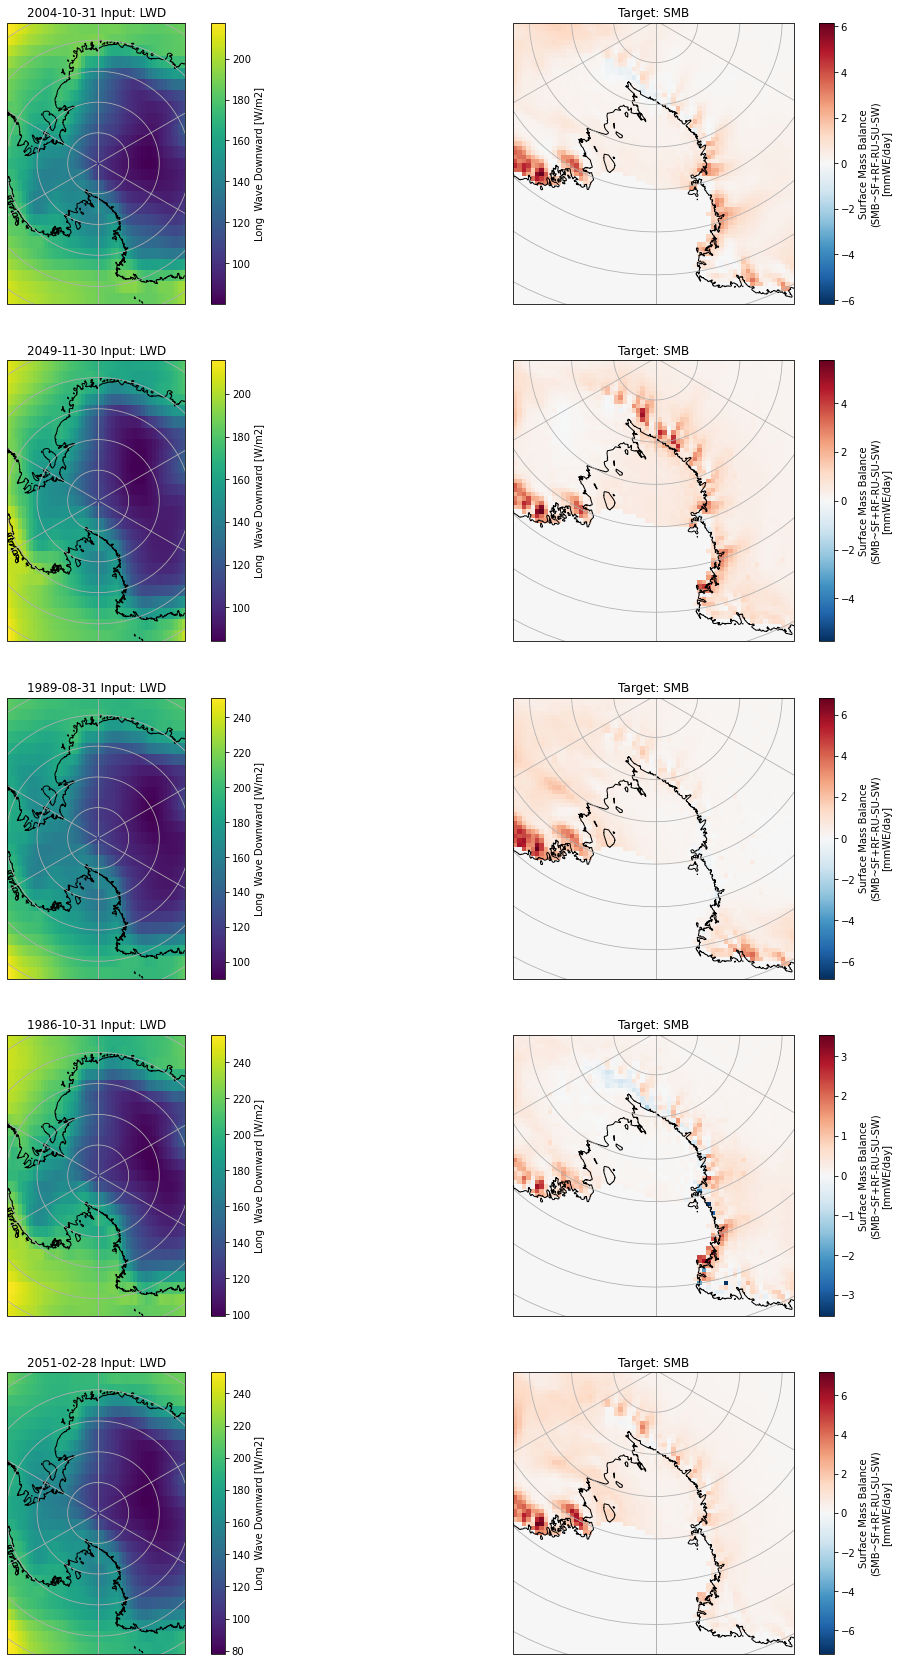

In [63]:
f = plt.figure(figsize=(20, 30))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

N = 5
for i in range(N):
    sample2dtrain_, sample1dtrain_, sampletarget_, randTime = takeRandomSamples(
        full_input_train_ns, full_target_train, pred=False
    )
    dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
    time = str(dt.date[0])

    if region == "lower peninsula":
        sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
    else:
        sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)

    sampletarget_ = sampletarget_.reshape(
        sampletarget_.shape[1], sampletarget_.shape[0], 1
    )
    M = 2
    for m in range(M):
        if m == 0:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTrain(GCMLike, sample2dtrain_, 2, ax, time, VAR_LIST, region)
        if m == 1:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTarget(target_dataset, sampletarget_, ax, region)

### Fit model:

In [95]:
batch_size, epochs = 32, 100

In [ ]:
batch_size, epochs = 32, 100
callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.7, patience=4, verbose=1
    ),  ## callbacks to reduce the lr during the training
    EarlyStopping(
        monitor="val_loss", patience=15, verbose=1
    ),  ## Stops the fitting if val_loss does not improve after 15 iterations
    ModelCheckpoint(path_model, monitor="val_loss", verbose=1, save_best_only=True),
]  ## Save only best model

history = unet.fit(
    full_input_train,
    full_target_train[:, :, :, None],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(full_input_val, full_target_val[:, :, :, None]),
    callbacks=callbacks,
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.8572 - rmse_k: 0.4483 
Epoch 1: val_loss improved from inf to 18206.39062, saving model to Results/


2022-04-21 20:44:57.895114: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Results/assets
33/33 [==============================] - 531s 16s/step - loss: 0.8572 - rmse_k: 0.4483 - val_loss: 18206.3906 - val_rmse_k: 91.4843 - lr: 0.0050
Epoch 2/100


In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['rmse_k'])
plt.plot(history.history['val_rmse_k'])
plt.title('model rmse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Predictions:

In [64]:
# Load best model:
unet = keras.models.load_model(path_model, 
                                custom_objects = {"rmse_k": rmse_k})

In [65]:
# plot predictions:
training_pred = unet.predict(full_input_train)
val_pred = unet.predict(full_input_val)
testing_pred = unet.predict(full_input_test)

In [99]:
def takeRandomSamples(full_input, full_target, pred=False, full_prediction=None):
    randTime = rn.randint(0, len(full_input[0]-1))
    sample2dtrain = full_input[0][randTime]
    sample1dtrain = full_input[1][randTime]

    sampletarget = full_target[randTime]

    if pred:
        samplepred = full_prediction[randTime]

        return sample2dtrain, sample1dtrain, sampletarget, samplepred, randTime
    else:
        return sample2dtrain, sample1dtrain, sampletarget, randTime


def plotTrain(GCMLike, sample2dtrain, numVar, ax, time, list_var, region="whole antarctica"):
    if region == "lower peninsula":
        ds = createLowerInput(GCMLike, Nx=48, Ny=25, print_=False)

    elif region == "whole antarctica":
        ds = GCMLike

    VAR = list_var[numVar]
    coords = {"y": ds.coords["y"], "x": ds.coords["x"]}
    dftrain = xr.Dataset(coords=coords, attrs=ds.attrs)
    dftrain[VAR] = xr.Variable(
        dims=("y", "x"), data=sample2dtrain[:, :, numVar], attrs=ds[VAR].attrs
    )
    dftrain[VAR].plot(
        ax=ax, x="x", transform=ccrs.SouthPolarStereo(), add_colorbar=True, cmap='RdYlBu_r'
    )

    ax.coastlines("10m", color="black")
    ax.gridlines()

    ax.set_title(f"{time} Input: {VAR}")


def plotTarget(target_dataset, sampletarget, ax, vmin, vmax, region="whole antarctica"):
    if region == "lower peninsula":
        ds = createLowerTarget(target_dataset, Nx=64, Ny = 64, print_=False)

    elif region == "whole antarctica":
        ds = target_dataset

    coords = {"y": ds.coords["y"], "x": ds.coords["x"]}
    dftrain = xr.Dataset(coords=coords, attrs=ds.attrs)
    dftrain["SMB"] = xr.Variable(
        dims=("y", "x"), data=sampletarget[:, :, 0], attrs=ds["SMB"].attrs
    )
    pl = dftrain.SMB.plot(ax=ax, x="x", transform=ccrs.SouthPolarStereo(), add_colorbar=True, 
                          cmap='RdYlBu_r', vmin = vmin, vmax = vmax)
    ax.coastlines("10m", color="black")
    ax.gridlines()
    ax.set_title(f"Target: SMB")


def plotPred(target_dataset, samplepred, ax, vmin, vmax, region="whole antarctica"):
    if region == "lower peninsula":
        ds = createLowerTarget(target_dataset, Nx=64, Ny = 64, print_=False)

    elif region == "whole antarctica":
        ds = target_dataset
    coords = {"y": ds.coords["y"], "x": ds.coords["x"]}
    dftrain = xr.Dataset(coords=coords, attrs=ds.attrs)
    dftrain["SMB"] = xr.Variable(
        dims=("y", "x"), data=samplepred[:, :, 0], attrs=ds["SMB"].attrs
    )
    dftrain.SMB.plot(ax=ax, x="x", transform=ccrs.SouthPolarStereo(), add_colorbar=True, 
                          cmap='RdYlBu_r', vmin = vmin, vmax = vmax)
    ax.coastlines("10m", color="black")
    ax.gridlines()
    ax.set_title(f"Prediction: SMB")

#### Training:

In [93]:
from datetime import date
today = str(date.today())

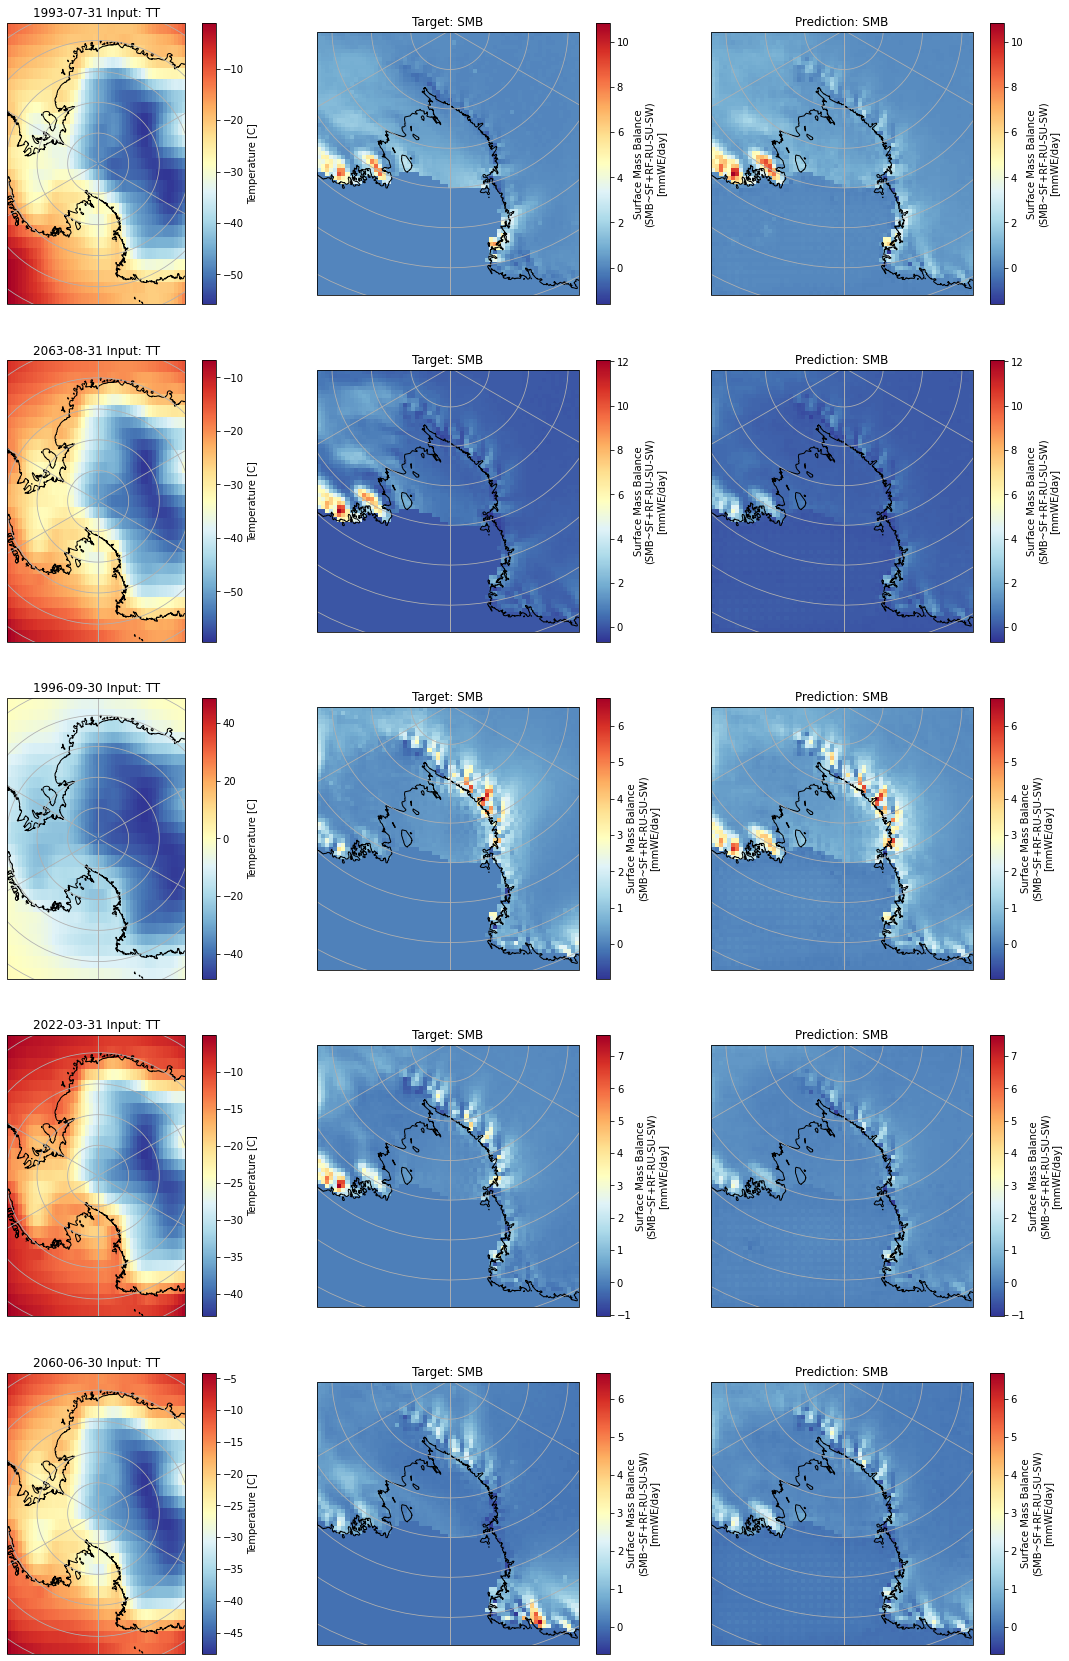

In [97]:
f = plt.figure(figsize=(20, 30))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

N = 5
for i in range(N):
    (
        sample2dtrain_,
        sample1dtrain_,
        sampletarget_,
        samplepred_,
        randTime,
    ) = takeRandomSamples(
        full_input_train_ns, full_target_train, pred=True, full_prediction=training_pred
    )
    dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
    time = str(dt.date[0])

    if region == "lower peninsula":
        sample2dtrain = resize(sample2dtrain_, 25, 48, print_=False)
    else:
        sample2dtrain = resize(sample2dtrain_, 25, 90, print_=False)

    sampletarget = sampletarget_.reshape(
        sampletarget_.shape[0], sampletarget_.shape[1], 1
    )

    samplepred = samplepred_.reshape(samplepred_.shape[0], samplepred_.shape[1], 1)
    
    vmin = np.min([sampletarget, samplepred])
    vmax = np.max([sampletarget, samplepred])

    M = 3
    for m in range(M):
        if m == 0:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTrain(GCMLike, sample2dtrain, 4, ax, time,VAR_LIST, region)
        if m == 1:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTarget(target_dataset, sampletarget, ax, vmin, vmax, region)
        if m == 2:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotPred(target_dataset, samplepred, ax, vmin, vmax, region)
            
plt.savefig(f'Results_plots/{today}_train_numepoch_{epochs}_bs_{batch_size}.png')

#### Test:

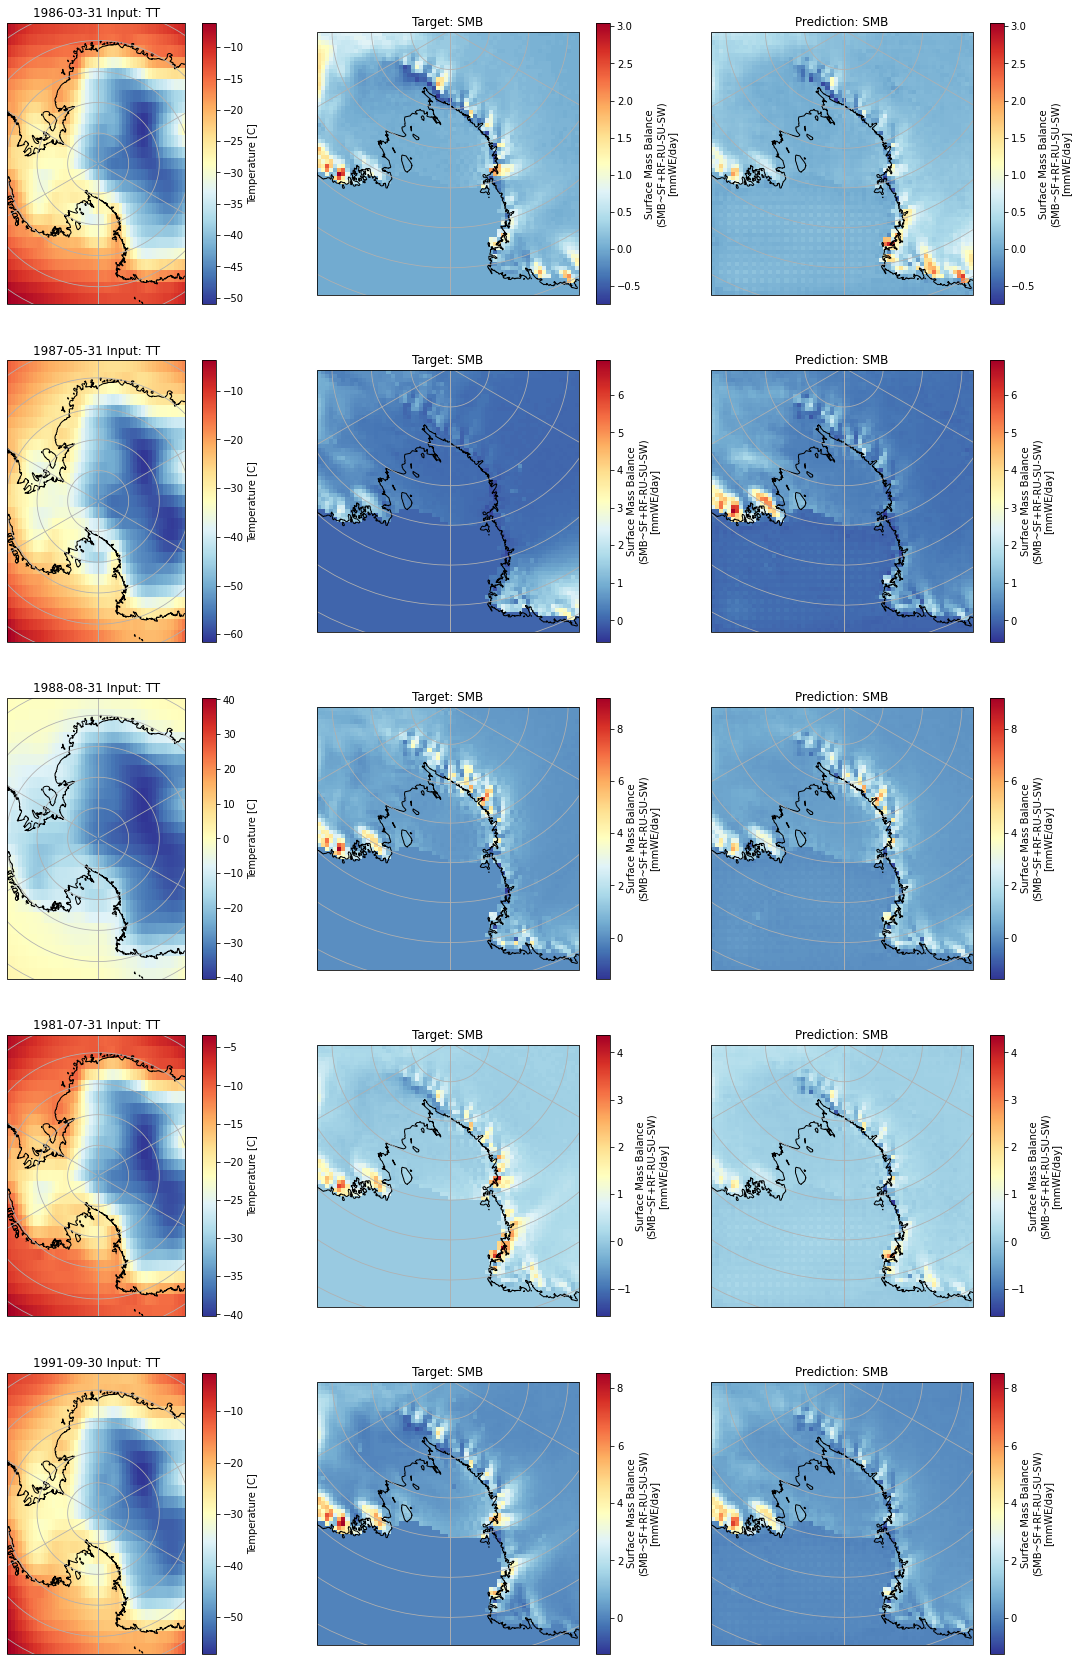

In [100]:
f = plt.figure(figsize=(20, 30))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

N = 5
for i in range(N):
    (
        sample2dtrain_,
        sample1dtrain_,
        sampletarget_,
        samplepred_,
        randTime,
    ) = takeRandomSamples(
        full_input_test_ns, full_target_test, pred=True, full_prediction=testing_pred
    )
    dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
    time = str(dt.date[0])

    if region == "lower peninsula":
        sample2dtrain = resize(sample2dtrain_, 25, 48, print_=False)
    else:
        sample2dtrain = resize(sample2dtrain_, 25, 90, print_=False)

    sampletarget = sampletarget_.reshape(
        sampletarget_.shape[0], sampletarget_.shape[1], 1
    )

    samplepred = samplepred_.reshape(samplepred_.shape[0], samplepred_.shape[1], 1)
    
    vmin = np.min([sampletarget, samplepred])
    vmax = np.max([sampletarget, samplepred])
    
    M = 3
    for m in range(M):
        if m == 0:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTrain(GCMLike, sample2dtrain, 4, ax, time,VAR_LIST, region)
        if m == 1:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotTarget(target_dataset, sampletarget, ax, vmin, vmax, region)
        if m == 2:
            ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
            plotPred(target_dataset, samplepred, ax, vmin, vmax, region)
            
plt.savefig(f'Results_plots/{today}_test_numepoch_{epochs}_bs_{batch_size}.png')

In [ ]:
plotAllVar(GCMLike, time = 0)

In [ ]:
plotAllVar(target_dataset, time = 0)

In [ ]:
plotAllVar(lowerInput, time = 0)